In [3]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import timeit
from tqdm import tqdm
print("imported!")

imported!


In [ ]:
# !pip install tqdm

  Obtaining dependency information for tqdm from https://files.pythonhosted.org/packages/00/e5/f12a80907d0884e6dff9c16d0c0114d81b8cd07dc3ae54c5e962cc83037e/tqdm-4.66.1-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ------- -------------------------------- 10.2/57.6 kB ? eta -:--:--
     ------- -------------------------------- 10.2/57.6 kB ? eta -:--:--
     -------------------- ----------------- 30.7/57.6 kB 146.3 kB/s eta 0:00:01
     -------------------- ----------------- 30.7/57.6 kB 146.3 kB/s eta 0:00:01
     -------------------- ----------------- 30.7/57.6 kB 146.3 kB/s eta 0:00:01
     -------------------- ----------------- 30.7/57.6 kB 146.3 kB/s eta 0:00:01
     -------------------- ----------------- 30.7/57.6 kB 146.3 kB/s eta 0:00:01
     -------------------- ----------------- 30.7/57.6 kB 146.3 kB/s eta 0:00:01
     --------------------------- ----------- 41.0/57.6 kB 78.8 kB/s eta 0:00:01
     -----------------------


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: C:\Users\izza\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


In [7]:
# initializing global constants and seeds to ensure reproducibility
RANDOM_SEED = 42
BATCH_SIZE = 100
EPOCHS = 40

# for reproduciniliity
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


LEARNING_RATE = 1e-4
NUM_CLASSES = 10
PATCH_SIZE = 4
IMG_SIZE = 28
IN_CHANNELS = 1
NUM_HEADS = 8
DROPOUT = 0.001
HIDDEN_DIMENSION = 768
ADAM_WEIGHT_DECAY = 0
ADAM_BETAS = (0.9,0.999)
ACTIVATION = "gelu"
NUM_ENCODERS = 4
EMBED_DIM = (PATCH_SIZE ** 2) * IN_CHANNELS
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE )

cpu


In [5]:
# creating patch and position embeddings, and adding cls token
class PatchEmbedding(nn.Module):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels):
        super().__init__()

        # create patches and flatten em
        self.patcher = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=embed_dim,
                kernel_size=patch_size,
                stride=patch_size,
            ),
            nn.Flatten(2)
        )

        #  create that extra token
        self.cls_token = nn.Parameter(torch.randn(size=(1,1, embed_dim)), requires_grad=True)
        # create position embeddings - learnable
        self.position_embeddings = nn.Parameter(torch.randn(size=(1, num_patches + 1, embed_dim)), requires_grad=True)

        self.dropout = nn.Dropout(p = dropout)

    def forward(self, x):
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)

        x = self.patcher(x).permute(0,2,1)

        x = torch.cat([cls_token, x], dim=1)

        # # print(f"x: {x}")
        # print(f"x.shape: {x.shape}")
        # print(self.position_embeddings)
        # print(f"position embeddinsg shape : {self.position_embeddings.shape}")

        x = self.position_embeddings + x

        x = self.dropout(x)

        return x
    
# testing
model = PatchEmbedding(EMBED_DIM, PATCH_SIZE, NUM_PATCHES, DROPOUT, IN_CHANNELS).to(DEVICE)
x = torch.randn(512, 1, 28, 28)
print(model(x).shape)

torch.Size([512, 50, 16])


In [6]:
# actual vision transformer
class ViT(nn.Module):
    def __init__(self, num_patches,
                 img_size,
                 num_classes, 
                 patch_size, 
                 embed_dim, 
                 num_encoders, 
                 num_heads, 
                 hidden_dim, 
                 dropout, 
                 activation, 
                 in_channnels):
        super().__init__()

        #  patch and position embeddings
        self.embeddings_block = PatchEmbedding(
            embed_dim,
            patch_size,
            num_patches,
            dropout,
            in_channnels
        )

        # defining a single encoder layer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, 
            nhead=num_heads, 
            dropout=dropout, 
            activation=activation, 
            batch_first=True,
            norm_first=False)
        
        # we have encoder layers stacked on top of each other
        self.encoder_block = nn.TransformerEncoder(encoder_layer=encoder_layer, num_layers=num_encoders)

        # multilayer perceptron
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embed_dim),
            nn.Linear(in_features=embed_dim, out_features=num_classes)
        )
    
    def forward(self, x):
        x = self.embeddings_block(x)
        x = self.encoder_block(x)
        x = self.mlp_head(x[:, 0, :])
        return x
    
# test running model
model = ViT(NUM_PATCHES, IMG_SIZE, NUM_CLASSES, PATCH_SIZE, EMBED_DIM, NUM_ENCODERS, NUM_HEADS, 
            HIDDEN_DIMENSION, DROPOUT, ACTIVATION, IN_CHANNELS).to(DEVICE)
x = torch.randn(512, 1, 28, 28).to(DEVICE)
print(model(x).shape)


torch.Size([512, 10])


In [9]:
# reading data - replace with your data path
train_df = pd.read_csv("./dataset/train.csv")
test_df = pd.read_csv("./dataset/test.csv")

In [10]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# split train data into train and validation data
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=RANDOM_SEED, shuffle=True)

In [13]:
# defining classes for datasets (train, validate, test)

class MNISTTrainDataset(Dataset):
    def __init__(self,
                 images, 
                 labels, 
                 indices):
        self.images = images
        self.labels = labels
        self.indices = indices
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
        ])

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = self.images[index].reshape((28,28)).astype(np.uint8)
        label = self.labels[index]
        idx = self.indices[index]
        image = self.transform(image)

        return {
            "image": image,
            "label": label,
            "index": idx,
        }
    
class MNISTValidateDataset(Dataset):
    def __init__(self,
                 images, 
                 labels, 
                 indices):
        self.images = images
        self.labels = labels
        self.indices = indices
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
        ])

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = self.images[index].reshape((28,28)).astype(np.uint8)
        label = self.labels[index]
        idx = self.indices[index]
        image = self.transform(image)

        return {
            "image": image,
            "label": label,
            "index": idx,
        }
    
class MNISTTestDataset(Dataset):
    def __init__(self,
                 images, 
                 indices):
        self.images = images
        self.indices = indices
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
        ])

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = self.images[index].reshape((28,28)).astype(np.uint8)
        idx = self.indices[index]
        image = self.transform(image)

        return {
            "image": image,
            "index": idx,
        }

37800
{'image': tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0

<Figure size 640x480 with 0 Axes>

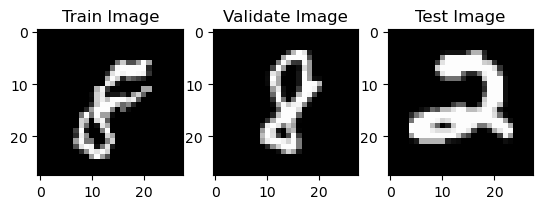

In [18]:
# plotting a random image from each dataset
plt.figure()
f,axarr = plt.subplots(1, 3)

train_dataset = MNISTTrainDataset(train_df.iloc[:, 1:].values.astype(np.uint8), train_df.iloc[:, 0].values, train_df.index.values)
print(len(train_dataset))
print(train_dataset[0])
axarr[0].imshow(train_dataset[0]["image"].squeeze(), cmap = "gray")
axarr[0].set_title("Train Image")
print("-"*10)

validate_dataset = MNISTValidateDataset(val_df.iloc[:, 1:].values.astype(np.uint8), val_df.iloc[:, 0].values, val_df.index.values)
print(len(validate_dataset))
print(validate_dataset[0])
axarr[1].imshow(validate_dataset[0]["image"].squeeze(), cmap = "gray")
axarr[1].set_title("Validate Image")
print("-"*10)

test_dataset = MNISTTestDataset(test_df.values.astype(np.uint8),  test_df.index.values)
print(len(test_dataset))
print(test_dataset[0])
axarr[2].imshow(test_dataset[0]["image"].squeeze(), cmap = "gray")
axarr[2].set_title("Test Image")
print("-"*10)


In [21]:
# defining dataloaders
train_dl = DataLoader(dataset=train_dataset,
                      batch_size=BATCH_SIZE,
                      shuffle=True)

validate_dl = DataLoader(dataset=validate_dataset,
                      batch_size=BATCH_SIZE,
                      shuffle=True)

test_dl = DataLoader(dataset=test_dataset,
                      batch_size=BATCH_SIZE,
                      shuffle=False)

In [ ]:
# model training
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), betas=ADAM_BETAS, lr=LEARNING_RATE, weight_decay=ADAM_WEIGHT_DECAY)

start = timeit.default_timer()

for epoch in tqdm(range(EPOCHS), position = 0, leave=True):
    model.train()

    train_labels = []
    train_preds = []
    train_running_loss = 0

    # train
    for index, img_label in enumerate(tqdm(train_dl, position = 0, leave = True)):
        img = img_label["image"].float().to(DEVICE)
        label = img_label["label"].type(torch.uint8).to(DEVICE)

        y_pred = model(img)
        y_pred_label = torch.argmax(y_pred, dim = 1)

        train_labels.extend(label.cpu().detach())

        train_preds.extend(y_pred_label.cpu().detach())

        loss = criterion(y_pred, label)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        train_running_loss += loss.item()

    train_loss = train_running_loss / (index + 1)

    model.eval()

    val_labels = []
    val_preds = []
    val_running_loss = 0

    # validate
    with torch.no_grad():
        for index, img_label in enumerate(tqdm(validate_dl, position = 0, leave = True)):
            img = img_label["image"].float().to(DEVICE)
            label = img_label["label"].type(torch.uint8).to(DEVICE)

            y_pred = model(img)
            y_pred_label = torch.argmax(y_pred, dim = 1)

            val_labels.extend(label.cpu().detach())
            val_preds.extend(y_pred_label.cpu().detach())

            loss = criterion(y_pred, label)
            val_running_loss += loss.item()

        val_loss = val_running_loss / (index + 1)

    print("-"*50)
    print(f"EPOCH {epoch + 1}")
    print(f"Train loss: {train_loss:.4f}")
    print(f"Valid loss: {val_loss:.4f}")
    print(f"Train Accuracy: {sum(1 for x, y in zip(train_preds, train_labels) if x == y) / len(train_labels)}")
    print(f"Validate Accuracy: {sum(1 for x, y in zip(val_preds, train_labels) if x == y) / len(train_labels)}")
    print("-"*50)

stop = timeit.default_timer()
print(f"training time: {stop-start:.2f} seconds")



In [ ]:
# testing
labels = []
ids = []
imgs = []
model.eval()

with torch.no_grad():
    for idx, sample in enumerate(tqdm(test_dl, position = 0, leave = True)):
        img = sample["image"].to(DEVICE)
#         ids.extend([int(i) + 1 for i in sample["index"]])
        outputs = model(img)
        imgs.extend(img.detach().cpu())
        labels.extend([int(i) for i in torch.argmax(outputs, dim=1)])

In [ ]:
# showing test predictions
plt.figure()
f,axarr = plt.subplots(2,3)
counter = 0
for i in range(2):
    for j in range(3):
        axarr[i][j].imshow(imgs[counter].squeeze(), cmap = "gray")
        axarr[i][j].set_title(f"Predicted Value: {labels[counter]}")
        counter += 1
plt.show()